In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from math import sqrt


In [3]:
data = pd.read_csv("data_clean.csv")


In [4]:
data.shape

(73196, 38)

In [5]:
data.columns

Index(['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'CONSTRUCTEDAREA',
       'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE', 'HASLIFT',
       'HASAIRCONDITIONING', 'HASPARKINGSPACE',
       'ISPARKINGSPACEINCLUDEDINPRICE', 'HASNORTHORIENTATION',
       'HASSOUTHORIENTATION', 'HASEASTORIENTATION', 'HASWESTORIENTATION',
       'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL', 'HASDOORMAN',
       'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
       'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
       'CADASTRALQUALITYID', 'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO',
       'DISTANCE_TO_CASTELLANA', 'LONGITUDE', 'LATITUDE', 'DISTRICT',
       'DISTRICT_CODE'],
      dtype='object')

In [6]:
data.sample(10)

,ASSETID,PERIOD,PRICE,UNITPRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,...,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_CASTELLANA,LONGITUDE,LATITUDE,DISTRICT,DISTRICT_CODE
67572,A15939979667107571139,201806,85000.0,1700.000000,50,2,1,0,0,0,...,0,0,1,4.594190,0.274311,3.919043,-3.740909,40.386520,Carabanchel,2
67960,A16741192310803869394,201806,89000.0,1369.230769,65,3,1,1,0,0,...,0,0,1,4.635055,1.485626,2.205284,-3.671081,40.383225,Puente de Vallecas,12
64195,A27247269724688258,201812,71000.0,2366.666667,30,1,1,0,0,0,...,0,0,1,4.403329,0.456031,2.637928,-3.663786,40.391357,Puente de Vallecas,12
53230,A11552141465832541335,201809,135000.0,2500.000000,54,1,1,0,0,0,...,0,0,1,4.517442,0.282218,2.793763,-3.655586,40.433918,Ciudad Lineal,6
10307,A16709237050191631719,201803,236000.0,5619.047619,42,1,1,0,1,0,...,0,0,1,2.566459,0.050514,1.260704,-3.675539,40.424893,Salamanca,14
54376,A11406479654113676560,201812,375000.0,5357.142857,70,2,1,0,1,0,...,0,0,1,2.367061,0.334412,1.989009,-3.714736,40.436153,Chamberi,5
33775,A8714357783115939502,201806,192000.0,5189.189189,37,1,1,0,1,1,...,0,1,0,1.271923,0.162787,1.134848,-3.703545,40.428014,Centro,3
2401,A4999009845245714106,201803,299000.0,6500.000000,46,1,1,0,0,0,...,0,0,1,2.035211,0.401336,0.288426,-3.686178,40.429020,Salamanca,14
28848,A1170318446540506429,201809,168000.0,2584.615385,65,3,1,0,0,0,...,0,0,1,5.734661,0.420878,3.899012,-3.643153,40.439465,Ciudad Lineal,6
13149,A18107916941272503597,201803,890000.0,3632.653061,245,3,3,1,1,1,...,0,0,1,7.619005,4.039466,6.432725,-3.765167,40.466614,Moncloa-Aravaca,10


In [9]:
target = 'PRICE'

features = [
    'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
    'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'HASGARDEN',
    'HASPARKINGSPACE', 'HASBOXROOM', 'HASWARDROBE', 'HASDOORMAN',
    'HASSWIMMINGPOOL', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
    'HASNORTHORIENTATION', 'HASSOUTHORIENTATION',
    'HASEASTORIENTATION', 'HASWESTORIENTATION',
    'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_CASTELLANA',
    'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
    'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
    'DISTRICT'
]


data_clean = data[features + [target]].dropna()


X = data_clean.drop(columns=[target])
y = data_clean[target]


ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
district_encoded = ohe.fit_transform(X[['DISTRICT']])
district_cols = ohe.get_feature_names_out(['DISTRICT'])


X_encoded = pd.concat([
    X.drop(columns=['DISTRICT']).reset_index(drop=True),
    pd.DataFrame(district_encoded, columns=district_cols)
], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.05],
    'subsample': [0.8, 1]
}

grid_search = GridSearchCV(
    xgb, param_grid, cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

y_pred = grid_search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")


Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
MAE: 52,666.76
RMSE: 88,934.72
R² Score: 0.9193


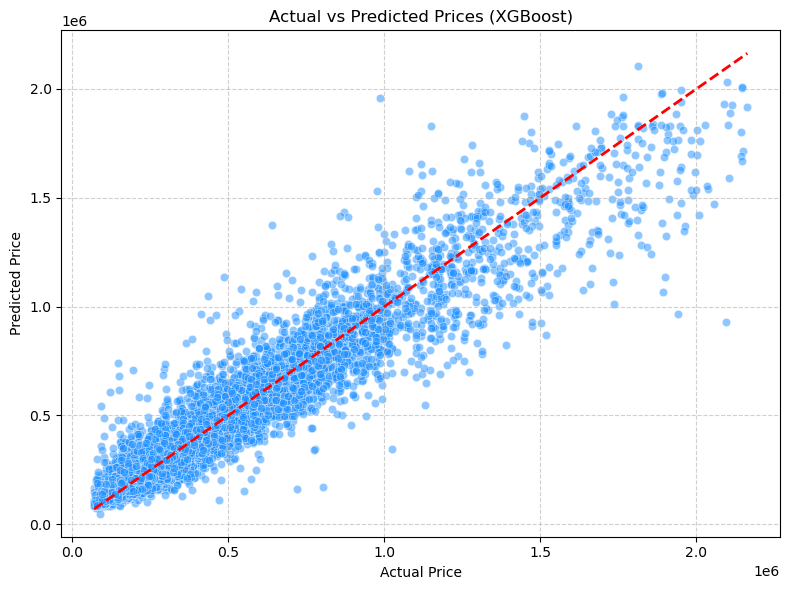

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (XGBoost)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [11]:
df_errors = pd.DataFrame({
    'real': y_test,
    'predicho': y_pred
})

df_errors['ape'] = np.abs(df_errors['real'] - df_errors['predicho']) / df_errors['real'] * 100 

bins = [0, 5, 10, 15, 20, 25, 50, 100, np.inf]
labels = ['<=5%', '<=10%', '<=15%', '<=20%', '<=25%', '<=50%', '<=100%', '>100%']

df_errors['rango_error'] = pd.cut(df_errors['ape'], bins=bins, labels=labels, right=True)

tabla_error = df_errors['rango_error'].value_counts(normalize=True).sort_index() * 100

tabla_error

tabla_error_df = tabla_error.reset_index()
tabla_error_df.columns = ['Rango de error %', 'Porcentaje de predicciones']
tabla_error_df


,Rango de error %,Porcentaje de predicciones
0,<=5%,22.923497
1,<=10%,20.778689
2,<=15%,16.919399
3,<=20%,12.950820
4,<=25%,8.661202
5,<=50%,14.153005
6,<=100%,2.984973
7,>100%,0.628415


In [13]:
!pip install lightgbm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------------------------------ --- 1.3/1.5 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 8.4 MB/s eta 0:00:00


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 58556, number of used features: 48
[LightGBM] [Info] Start training from score 364393.230412
Best parameters: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 200, 'subsample': 0.8}
MAE: 54,031.73
RMSE: 90,333.94
R² Score: 0.9168


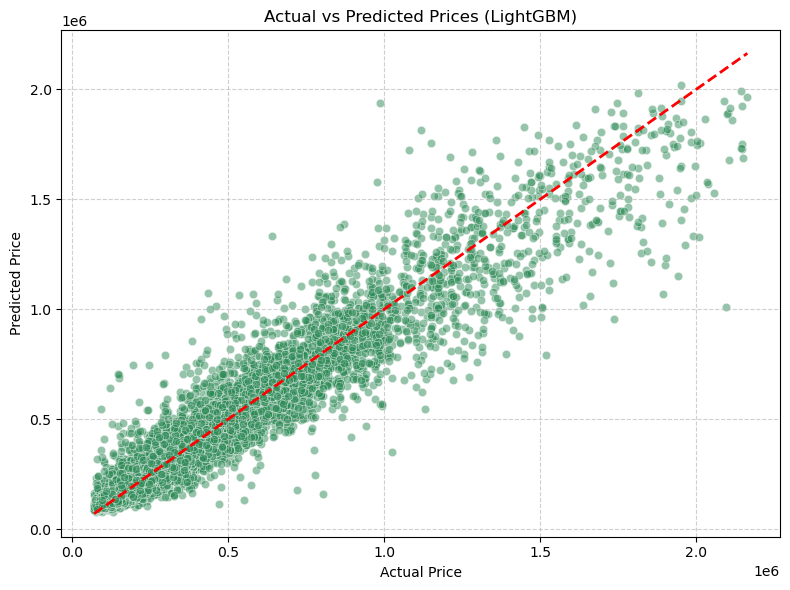

In [14]:
features = [
    'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
    'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'HASGARDEN',
    'HASPARKINGSPACE', 'HASBOXROOM', 'HASWARDROBE', 'HASDOORMAN',
    'HASSWIMMINGPOOL', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
    'HASNORTHORIENTATION', 'HASSOUTHORIENTATION',
    'HASEASTORIENTATION', 'HASWESTORIENTATION',
    'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_CASTELLANA',
    'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
    'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3', 'DISTRICT'
]

target = 'PRICE'

# -----------------------------
# 2. Preparar datos
# -----------------------------
drop_cols = ['OTHER_UNUSED_COLUMNS_IF_ANY']  # Puedes ignorar esto si ya limpiaste antes
cols_for_model = [col for col in features if col != 'DISTRICT'] + ['DISTRICT', target]
data_clean = data[cols_for_model].dropna()

X = data_clean.drop(columns=[target])
y = data_clean[target]

# -----------------------------
# 3. One-hot encoding para DISTRICT
# -----------------------------
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
district_encoded = ohe.fit_transform(X[['DISTRICT']])
district_cols = ohe.get_feature_names_out(['DISTRICT'])

X_encoded = pd.concat([
    X.drop(columns=['DISTRICT']).reset_index(drop=True),
    pd.DataFrame(district_encoded, columns=district_cols)
], axis=1)

# -----------------------------
# 4. Split train/test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# -----------------------------
# 5. Definir modelo y grid search
# -----------------------------
lgb_model = LGBMRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10, None],
    'learning_rate': [0.1, 0.05],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    lgb_model,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# -----------------------------
# 6. Evaluación
# -----------------------------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Best parameters: {grid_search.best_params_}")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

# -----------------------------
# 7. Visualización: Predicted vs Actual
# -----------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (LightGBM)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()